# Anomaly Detection on Washer Data Set Using U-Net Xception-Style Model.

# U-Net Xception-Style Modelを用いたWasherデータセットの異常検知。

# Import Necessary Packages.

# 必要なパッケージをインポートします。

In [13]:
import os
import PIL
import numpy as np
from PIL import ImageOps
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

# Define Data Directory.

# データディレクトリの定義。

In [2]:
washer_ok_img = os.listdir("washer/washer_ok")
washer_ng_img = os.listdir("washer/washer_ng/kizu")
washer_test_img = os.listdir("washer/washer_ng/sabi")

# Set Up Training Data Path.

# トレーニングデータのパスを設定します。

In [3]:
train_path = []

for  ok_img in washer_ok_img[:30] :
    train_path.append('washer/washer_ok/'+ok_img)
    #valid_path.append('washer/washer_ng/kizu/'+ng_img)

print(len(train_path))



30


# Set Up Validation Data Path.

# バリデーションデータのパスを設定します。

In [4]:
valid_path = []

for ng_img in washer_ng_img[:10]:
    valid_path.append('washer/washer_ng/kizu/'+ng_img)
    
print(len(valid_path))

10


# Set Up Test Data Path.

# テストデータのパスの設定します。

In [5]:
test_path = []

for test_img in washer_test_img:
    test_path.append('washer/washer_ng/sabi/'+test_img)

print(len(test_path))

4


# Define: Image Size, Batch Size, Number of Classes.


# 定義します: 画像サイズ、バッチサイズ、クラスの数。

In [6]:
img_size = (160, 160)
# 256 , 256
batch_size = 1
num_classes = 2

# Prepare Sequence Class to Load and Vectorize Batches of Data.

# データのバッチをロードしてベクター化するためのシーケンスクラスを用意すします。

In [7]:
class Washer(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        #pass
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Return input correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y

# Implement U-Net Xception-Style  Model.

# U-Net Xception-Style  Model モデルの実装。

In [8]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes,3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)



# U-Net Xception-Style  Model Architecture.

# U-Net Xception-Style モデルのアーキテクチャ。

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

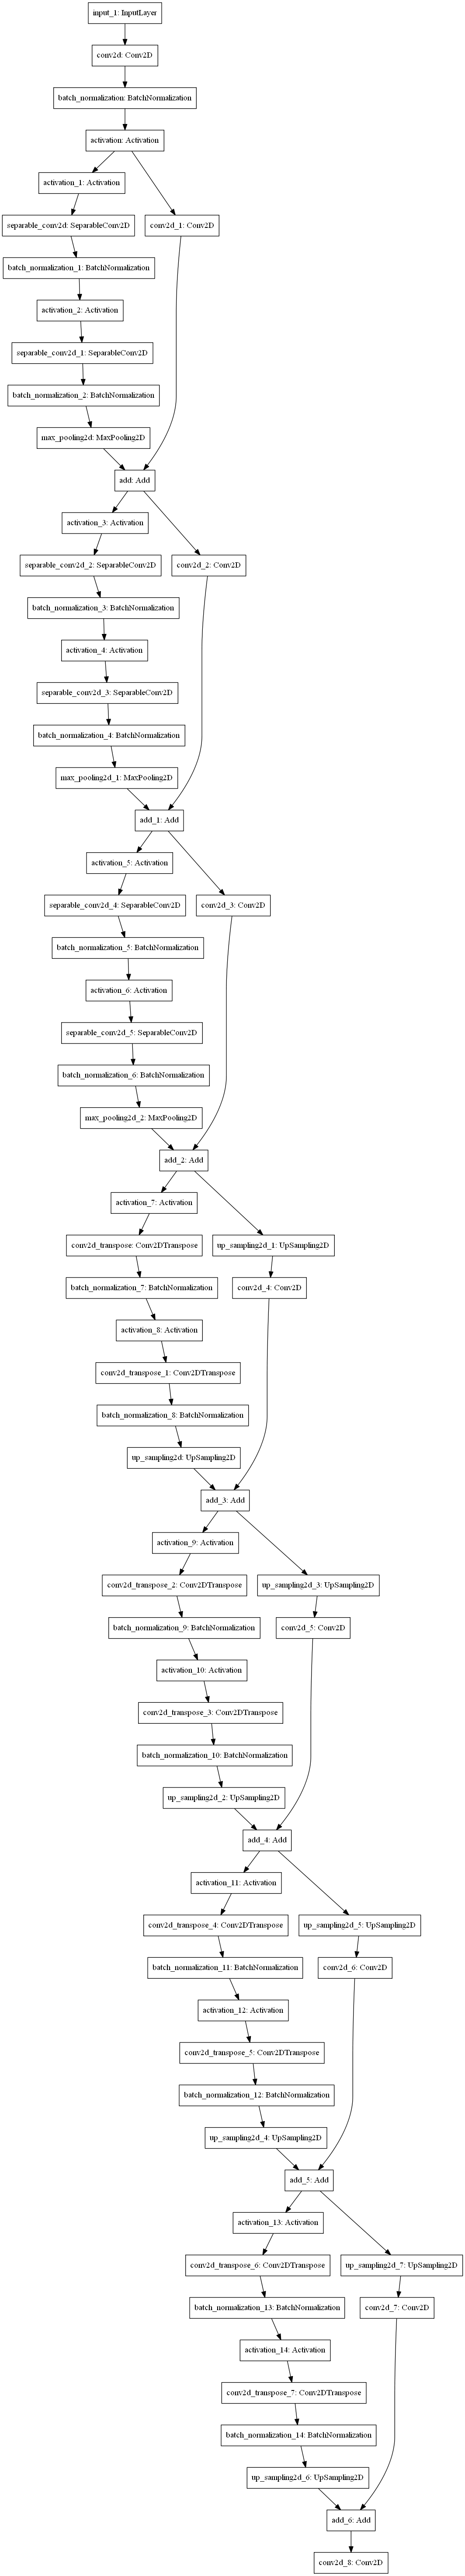

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='U-Net_Xception_Style.png')

# Instantiate Data Sequences .

# データシーケンスのインスタンス化 。

In [16]:
# Instantiate data Sequences for each split
train_gen = Washer(batch_size, img_size, train_path)
val_gen = Washer(batch_size, img_size, valid_path)
test_gen = Washer(batch_size, img_size, test_path)

# Train U-Net Xception-Style Model.

# U-Net Xception-Style Modelモデルの学習。

In [15]:
# Configure the model for training.

opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("washer_segmentation_U-Net_Xecption_Style.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
30/30 [==============================] - 7s 249ms/step - loss: 186.9564 - val_loss: 141.9754
Epoch 2/30
30/30 [==============================] - 7s 217ms/step - loss: 145.0933 - val_loss: 134.4549
Epoch 3/30
30/30 [==============================] - 7s 219ms/step - loss: 144.5971 - val_loss: 133.3895
Epoch 4/30
30/30 [==============================] - 7s 219ms/step - loss: 144.4790 - val_loss: 133.1409
Epoch 5/30
30/30 [==============================] - 6s 216ms/step - loss: 144.4394 - val_loss: 133.0636
Epoch 6/30
30/30 [==============================] - 7s 219ms/step - loss: 144.4096 - val_loss: 133.0228
Epoch 7/30
30/30 [==============================] - 6s 216ms/step - loss: 144.3810 - val_loss: 132.9793
Epoch 8/30
30/30 [==============================] - 7s 218ms/step - loss: 144.3605 - val_loss: 132.9593
Epoch 9/30
30/30 [==============================] - 6s 215ms/step - loss: 144.3487 - val_loss: 132.9303
Epoch 10/30
30/30 [==============================] - 6s 216ms/st

# Loss and Validation Loss Curve.

# 損失とバリデーションの損失曲線.

<AxesSubplot:>

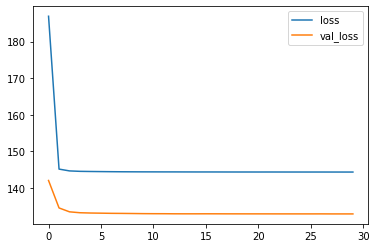

In [17]:
import pandas as pd
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

# Predictions for Images in Test Data Set.

# テストデータセットに含まれる画像の予測値です。

In [18]:
# Generate predictions for all images in the test set
test_gen = Washer(1, img_size, test_path)
test_preds = model.predict(test_gen)

# Inference Test Data with Heat Map.
# ヒートマップによる推論テストデータ。

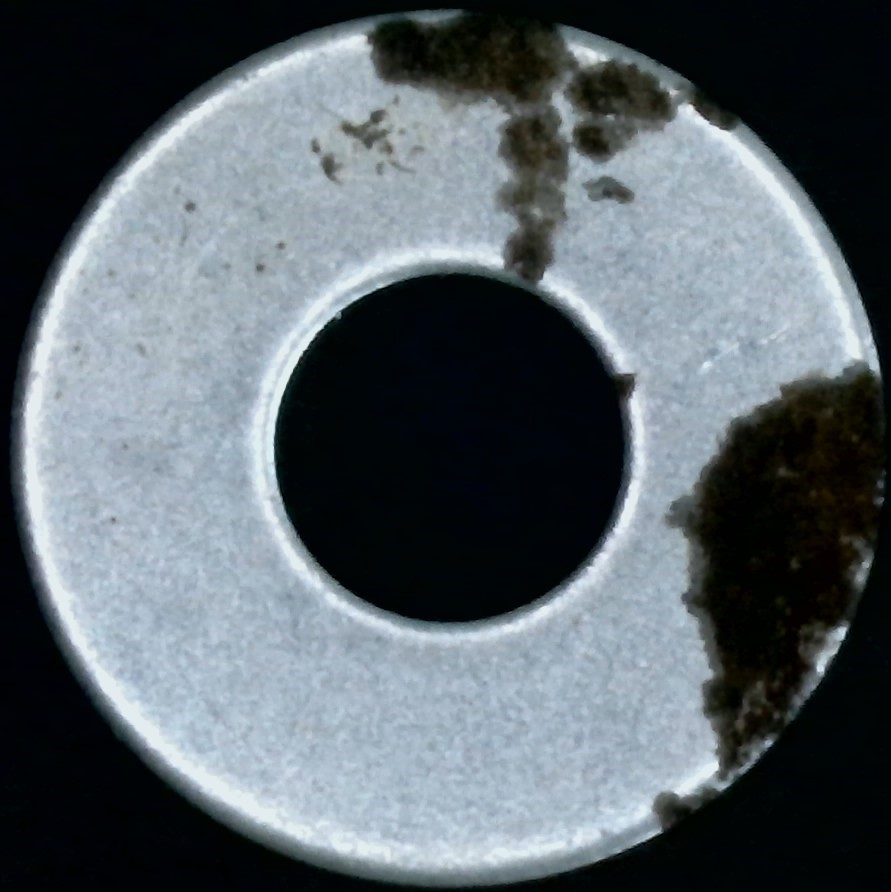

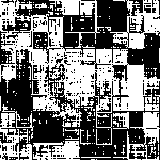

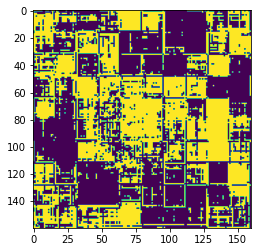

In [21]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    plt.imshow(mask)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for test image
i = 1

# Display input image
display(Image(filename=test_path[i], width=256, height=256))

# Display mask predicted by our model
display_mask(i)  